In [0]:
%sh

apt-get install graphviz -y

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fonts-liberation libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin libgvc6
  libgvpr2 liblab-gamut1 libpathplan4
Suggested packages:
  graphviz-doc
The following NEW packages will be installed:
  fonts-liberation graphviz libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin
  libgvc6 libgvpr2 liblab-gamut1 libpathplan4
0 upgraded, 11 newly installed, 0 to remove and 24 not upgraded.
Need to get 2701 kB of archives.
After this operation, 11.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 fonts-liberation all 1:1.07.4-11 [822 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libann0 amd64 1.1.2+doc-7build1 [26.0 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libcdt5 amd64 2.42.2-3build2 [18.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libcgraph6 amd64 

In [0]:
%sh

pip install dtreeviz[pyspark]

  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425367 sha256=3e71c395970a8faf9ac39d3bed9658a79dd6754e564de7c4a053dbe1c469f04d
  Stored in directory: /root/.cache/pip/wheels/a6/ce/f9/17d82c92f044018df2fe30af63ac043447720d5b2cee39b40f
Successfully built pyspark
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import IntegerType, DoubleType
from pyspark import SparkFiles
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dtreeviz

In [0]:
# 그래프 모양 설정
plt.style.use("seaborn")
# 글자 크기설정
sns.set(font_scale = 2)

In [0]:
# 경고 메시지가 출력되지 않도록 설정
import warnings
warnings.filterwarnings("ignore")

In [0]:
# 구글 드라이브의 titanic.csv 다운 경로
url = "https://drive.google.com/uc?id=1lr7b1GbVARHpIQP-xw7UVD2R7al9bYKg"


In [0]:
# url로부터 다운 받은 파일 폴더 저장
spark.sparkContext.addFile(url)

In [0]:
# 폴더 경로 조회
SparkFiles.getRootDirectory()

Out[8]: '/local_disk0/spark-93aba7bc-151b-4564-ba96-1652b08230a6/userFiles-91910911-bf91-4658-b890-e6d512ce8c87'

In [0]:
# 폴더 파일 리스트 조회
os.listdir(SparkFiles.getRootDirectory())

Out[9]: ['uc']

In [0]:
# 다운 받은 폴더의 파일 중 파일명 uc 를 읽어서 리턴받아
# csv 파일을 SparkDataFrame 으로 생성, header=True : csv 파일의 첫번째 줄은 칸 이름인 것을 명시
df_train = spark.read.csv("file://"+SparkFiles.get("uc"), header=True)


## 모델 학습을 위한 전처리 과정

In [0]:
col_name_list = df_train.schema.names

In [0]:
# int 타입으로 바꿔야할 컬럼명들
int_col_names = col_name_list[1:2] + col_name_list[5:7] + col_name_list[11:12]

print(int_col_names)

['Pclass', 'SibSp', 'Parch', 'Survived']


In [0]:
# int 타입으로 변경

for i in int_col_names:
    print("컬럼명 : ", i)
    df_train = df_train.withColumn(i , df_train[i].cast("int"))
    print("="*100)

컬럼명 :  Pclass
컬럼명 :  SibSp
컬럼명 :  Parch
컬럼명 :  Survived


In [0]:
# double 타입으로 바꿔야할 컬럼명들
double_col_names = col_name_list[4:5] + col_name_list[8:9]

print(double_col_names)

['Age', 'Fare']


In [0]:
# double 타입으로 변경

for i in double_col_names:
    print("컬럼명 : ", i)
    df_train = df_train.withColumn(i , df_train[i].cast("double"))
    print("="*100)

컬럼명 :  Age
컬럼명 :  Fare


In [0]:
# 변경된 지 컬럼 타입 다시 조회
df_train.schema

Out[16]: StructType(List(StructField(PassengerId,StringType,true),StructField(Pclass,IntegerType,true),StructField(Name,StringType,true),StructField(Sex,StringType,true),StructField(Age,DoubleType,true),StructField(SibSp,IntegerType,true),StructField(Parch,IntegerType,true),StructField(Ticket,StringType,true),StructField(Fare,DoubleType,true),StructField(Cabin,StringType,true),StructField(Embarked,StringType,true),StructField(Survived,IntegerType,true)))

In [0]:
# SQL 사용을 위해 SparkDataFrame 을 View(데이터 추가-수정 불가능 테이블) 형태로 변환
df_train.createOrReplaceTempView('titanic_view')

In [0]:
# Fare 컬럼 값들이 위와 같이 매우 비대칭이므로
## 모델 학습 시, outlier에 대해 민감하게 반응할 수 있다.
### outlier의 영향을 줄이기 위해 log 값으로 변환-대입

from pyspark.sql.functions import log1p

# log1p(x) : log(1+x) 연산, x값이 0일 경우에 대비
df_train=df_train.withColumn("Fare", log1p("Fare"))

In [0]:
# SibSp : 배우자 수 , Parch : 동승한 부모 자식 수
## SibSp+Parch+1 : SibSp=0, Parch=0 일 경우, 본인 1명은 있어야하므로 +1
df_train = df_train.withColumn("FamilySize", df_train["SibSp"]+df_train["Parch"]+1)

In [0]:
import re

# 다음 단어 중 하나를 포함한 문자열을 찾기 위한 객체 생성
p = re.compile("Mrs|Mr|Miss|Master|Don|Dr|Ms|Major|Mlle|Mme|Countess|Lady")

In [0]:
# 이름으로부터 Mr Mrs Miss 리턴 함수

def get_sir(name) :
    if p.search(name) != None:
        if p.search(name)[0] in ['Countess', 'Lady']:
            return "Mrs"
        elif p.search(name)[0] in ["Mme", "Ms", "Mlle"]:
            return "Miss"
        elif p.search(name)[0] in ["Don", "Dr", "Major"]:
            return "Mr"
        else:
            return p.search(name)[0]
    else:
        return "Other"


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [0]:
# udf(lambda 컬럼의 데이터 하나씩 저장할 변수: 함수명, 리턴받을 결과의 타입)
udf_get_sir = udf(lambda x:get_sir(x), StringType())

In [0]:
df_train = df_train.withColumn("Sir", udf_get_sir(df_train["Name"]))

In [0]:
sir_df = df_train[["Sir","Age"]].groupby("Sir").mean()

In [0]:
sir_df = sir_df.withColumnRenamed("avg(Age)","avg_age")

In [0]:
sir_df = sir_df.toPandas()

#  index가 행번호로 되어있음.

In [0]:
sir_df.set_index("Sir",inplace=True)

In [0]:
sir_df.to_dict()

Out[29]: {'avg_age': {'Miss': 21.86,
  'Other': 48.3,
  'Master': 4.574166666666667,
  'Mr': 32.65158924205379,
  'Mrs': 36.0}}

In [0]:
sir_df.to_dict()["avg_age"]

Out[30]: {'Miss': 21.86,
 'Other': 48.3,
 'Master': 4.574166666666667,
 'Mr': 32.65158924205379,
 'Mrs': 36.0}

In [0]:
sir_df_dic = sir_df.to_dict()["avg_age"]

In [0]:
# Age 컬럼 값이 결측치일 때 Sir 컬럼의 Mr Mrs Miss 의 평균 리턴
import math

def get_age(age, sir):
    # 함수 외부에서 선언한 변수 sir_df_dic 사용
    global sir_df_dic

    # 결측치인 나이 컬럼 값이 있는 확인
    # 결측치인 경우 Sir 값에 따라 평균 나이로 대체 
    if (age is None) or (len(str(age))==0) or math.isnan(age):
        return sir_df_dic[sir]
    else:
        return age

In [0]:
# udf 와 get_age() 함수를 통해
## Spark DataFrame 의 컬럼 값들을 수정해서 리턴
from pyspark.sql.types import DoubleType

udf_get_age = udf(lambda age, sir:get_age(age,sir), DoubleType())

In [0]:
df_train = df_train.withColumn("Age", udf_get_age(df_train["Age"], df_train["Sir"]))

In [0]:
# 결측값 S로 대체
df_train = df_train.fillna({'Embarked':'S'})

Out[36]: <AxesSubplot:>

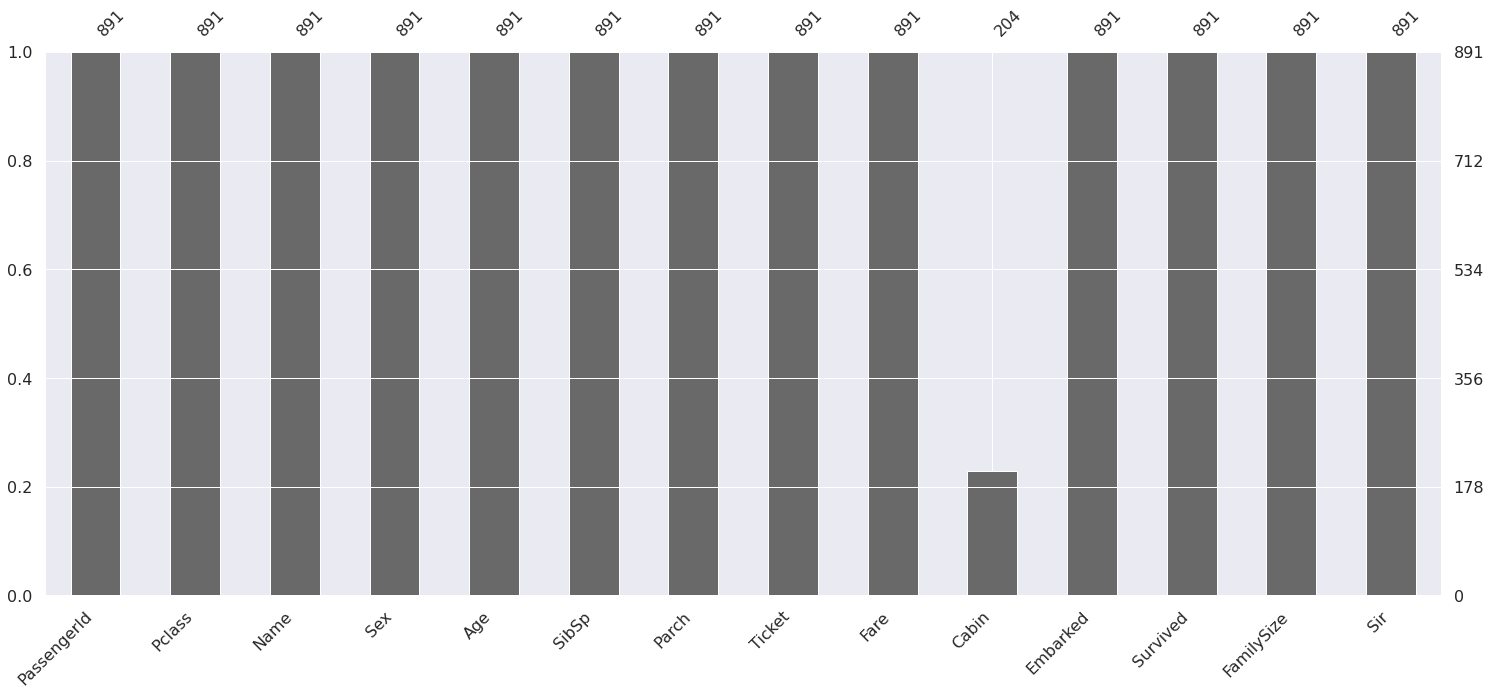

In [0]:
import missingno as msno

# msno.bar() : 각 컬럼의 null 이 아닌 데이터의 비율을 그래프로 그려주는 모듈
msno.bar(df=df_train.toPandas())


- 위의 결과로부터 `Cabin` 컬럼값을 제외한 나머지 컬럼들의 결측치는 조회되지 않는다
- `Cabin` 의 경우, 결측치가 너무 많고 데이터가 너무 다양해 학습 결과에 영향 X, 삭제할 예정

In [0]:
# 나
# 이의 10의 자리 수만  가져와
# 해당 값들을 나이 컬럼의 대표값으로 대체

def get_age_category(age):

    return age //10

In [0]:
udf_get_age_category = udf(lambda x:get_age_category(x), DoubleType())

df_train = df_train.withColumn("Age_Category", udf_get_age_category(df_train["Age"]))

In [0]:
from pyspark.ml.feature import StringIndexer

In [0]:
# Sir 컬럼을 이용해 Sir_Category 컬럼 생성

string_indexer = StringIndexer(inputCols=["Sir"], outputCols=["Sir_Category"])

In [0]:
# Sir 컬럼 문자열 파악
sir_transformer = string_indexer.fit(df_train)

In [0]:
df_train = sir_transformer.transform(df_train)

# Mr -> 0, Miss -> 1, Mrs -> 2, Master -> 3, Other -> 4
## 각 컬럼값들의 빈도수순으로 index 값이 정해짐

In [0]:
string_indexer = StringIndexer(inputCols=["Embarked"], outputCols=["Embarked_Category"])

In [0]:
embarked_transformer = string_indexer.fit(df_train)

In [0]:
df_train = embarked_transformer.transform(df_train)

In [0]:
string_indexer = StringIndexer(inputCols=["Sex"], outputCols=["Sex_Category"])

In [0]:
sex_transformer = string_indexer.fit(df_train)

In [0]:
df_train = sex_transformer.transform(df_train)


---


# ML(Machine Learning)

### 분류 학습, 타이타닉 생존자 분류


### 불필요 컬럼 삭제

In [0]:
df_train = df_train.drop("PassengerId")

In [0]:
df_train = df_train.drop("Name")

In [0]:
df_train = df_train.drop("Sex")

In [0]:
df_train =df_train.drop("Age")

In [0]:
df_train = df_train.drop("Ticket")

In [0]:
df_train = df_train.drop("Cabin")

In [0]:
df_train = df_train.drop("Embarked")

In [0]:
df_train = df_train.drop("Sir")

In [0]:
df_train.show(10)

+------+-----+-----+------------------+--------+----------+------------+------------+-----------------+------------+
|Pclass|SibSp|Parch|              Fare|Survived|FamilySize|Age_Category|Sir_Category|Embarked_Category|Sex_Category|
+------+-----+-----+------------------+--------+----------+------------+------------+-----------------+------------+
|     3|    1|    0|2.1102132003465894|       0|         2|         2.0|         0.0|              0.0|         0.0|
|     1|    1|    0|   4.2805931204649|       1|         2|         3.0|         2.0|              1.0|         1.0|
|     3|    0|    0| 2.188856327665703|       1|         1|         2.0|         1.0|              0.0|         1.0|
|     1|    1|    0|3.9908341858524357|       1|         2|         3.0|         2.0|              0.0|         1.0|
|     3|    0|    0|2.2027647577118348|       0|         1|         3.0|         0.0|              0.0|         0.0|
|     3|    0|    0| 2.246892662898172|       0|         1|     


### 학습 데이터 / 테스트 데이터 분리

In [0]:
df_train.columns

Out[64]: ['Pclass',
 'SibSp',
 'Parch',
 'Fare',
 'Survived',
 'FamilySize',
 'Age_Category',
 'Sir_Category',
 'Embarked_Category',
 'Sex_Category']

In [0]:
cols = df_train.columns

In [0]:
# 종속 변수 Survived 삭제 
cols.remove("Survived")

In [0]:
from pyspark.ml.feature import VectorAssembler

In [0]:
# 독립변수, 컬럼값들을 합쳐서 features 컬럼으로 생성
assembler = VectorAssembler(inputCols=cols, outputCol="features")

In [0]:
assembler_df = assembler.transform(df_train)

In [0]:
display(assembler_df.show(10))

+------+-----+-----+------------------+--------+----------+------------+------------+-----------------+------------+--------------------+
|Pclass|SibSp|Parch|              Fare|Survived|FamilySize|Age_Category|Sir_Category|Embarked_Category|Sex_Category|            features|
+------+-----+-----+------------------+--------+----------+------------+------------+-----------------+------------+--------------------+
|     3|    1|    0|2.1102132003465894|       0|         2|         2.0|         0.0|              0.0|         0.0|[3.0,1.0,0.0,2.11...|
|     1|    1|    0|   4.2805931204649|       1|         2|         3.0|         2.0|              1.0|         1.0|[1.0,1.0,0.0,4.28...|
|     3|    0|    0| 2.188856327665703|       1|         1|         2.0|         1.0|              0.0|         1.0|[3.0,0.0,0.0,2.18...|
|     1|    1|    0|3.9908341858524357|       1|         2|         3.0|         2.0|              0.0|         1.0|[1.0,1.0,0.0,3.99...|
|     3|    0|    0|2.202764757711

In [0]:
# assembler_df 의 데이터를 7:3 으로 나눠
## 70% : training data, 학습 데이터 / 30% : test data, 테스트데이터

(training_data, test_data) = assembler_df.randomSplit([0.7, 0.3])

In [0]:
display(training_data)

Pclass,SibSp,Parch,Fare,Survived,FamilySize,Age_Category,Sir_Category,Embarked_Category,Sex_Category,features
1,0,0,0.0,0,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 4, 5), values -> List(1.0, 1.0, 3.0))"
1,0,0,0.0,0,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 4, 5), values -> List(1.0, 1.0, 3.0))"
1,0,0,0.0,0,1,3.0,4.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 4, 5, 6), values -> List(1.0, 1.0, 3.0, 4.0))"
1,0,0,3.2804411805263554,0,1,4.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.2804411805263554, 1.0, 4.0))"
1,0,0,3.2930552230424524,0,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.2930552230424524, 1.0, 3.0))"
1,0,0,3.2932111997353943,1,1,4.0,0.0,0.0,1.0,"Map(vectorType -> dense, length -> 9, values -> List(1.0, 0.0, 0.0, 3.2932111997353943, 1.0, 4.0, 0.0, 0.0, 1.0))"
1,0,0,3.295836866004329,0,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.295836866004329, 1.0, 3.0))"
1,0,0,3.3064287218760624,1,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3064287218760624, 1.0, 3.0))"
1,0,0,3.3064287218760624,1,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3064287218760624, 1.0, 3.0))"
1,0,0,3.3064287218760624,1,1,4.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3064287218760624, 1.0, 4.0))"


In [0]:
display(test_data)

Pclass,SibSp,Parch,Fare,Survived,FamilySize,Age_Category,Sir_Category,Embarked_Category,Sex_Category,features
1,0,0,0.0,0,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 4, 5), values -> List(1.0, 1.0, 3.0))"
1,0,0,0.0,0,1,4.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 4, 5), values -> List(1.0, 1.0, 4.0))"
1,0,0,1.791759469228055,0,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 1.791759469228055, 1.0, 3.0))"
1,0,0,3.2932111997353943,1,1,4.0,2.0,0.0,1.0,"Map(vectorType -> dense, length -> 9, values -> List(1.0, 0.0, 0.0, 3.2932111997353943, 1.0, 4.0, 2.0, 0.0, 1.0))"
1,0,0,3.295836866004329,0,1,6.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.295836866004329, 1.0, 6.0))"
1,0,0,3.3100867049215847,1,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3100867049215847, 1.0, 3.0))"
1,0,0,3.3160025355989236,0,1,5.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3160025355989236, 1.0, 5.0))"
1,0,0,3.3160025355989236,0,1,6.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3160025355989236, 1.0, 6.0))"
1,0,0,3.3160025355989236,0,1,6.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3160025355989236, 1.0, 6.0))"
1,0,0,3.3160025355989236,1,1,5.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3160025355989236, 1.0, 5.0))"



### `RandomForest` 분류 모델 학습 구현

In [0]:
from pyspark.ml.classification import RandomForestClassifier

In [0]:
# DecisionTree 100개짜리의 RandomForestClassifier 객체 생성

rf = RandomForestClassifier(featuresCol="features", labelCol="Survived", numTrees=100)

In [0]:
# training_data를 이용해 RandomForest 에 포함된 Decision Tree 들을 만듦
rfModel = rf.fit(training_data)

In [0]:
rfModel

Out[82]: RandomForestClassificationModel: uid=RandomForestClassifier_c24a52b87d10, numTrees=100, numClasses=2, numFeatures=9

In [0]:
rf_prediction = rfModel.transform(test_data)

In [0]:
# 실제값, Survived 예측값, prediction 컬럼 조회
display(rf_prediction["Survived", "prediction"])

Survived,prediction
0,0.0
0,0.0
0,0.0
1,1.0
0,0.0
1,0.0
0,0.0
0,0.0
0,0.0
1,0.0


In [0]:
# 예측이 맞는 값들 저장
right_predict = rf_prediction.filter(rf_prediction.Survived == rf_prediction.prediction)


In [0]:
right_predict.count()

Out[86]: 241

In [0]:
rf_prediction.count()

Out[87]: 287

In [0]:
# 정확도 계산
right_predict.count() / rf_prediction.count()

Out[88]: 0.8397212543554007

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
# MulticlassClassificationEvaluator 를 이용해 정확도 다시 계산

evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="Survived", predictionCol ="prediction", metricName="accuracy"
)

In [0]:
evaluator_accuracy.evaluate(rf_prediction)

Out[93]: 0.8397212543554007


## `RandomForest` 시각화
<br>

- `Random Forest` 내의 `Decision Tree` 들이 어떻게 예측하는 지 시각화

In [0]:
dataset = training_data.toPandas()
dataset

,Pclass,SibSp,Parch,Fare,Survived,FamilySize,Age_Category,Sir_Category,Embarked_Category,Sex_Category,features
0,1,0,0,0.000000,0,1,3.0,0.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0)"
1,1,0,0,0.000000,0,1,3.0,0.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0)"
2,1,0,0,0.000000,0,1,3.0,4.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 3.0, 4.0, 0.0, 0.0)"
3,1,0,0,3.280441,0,1,4.0,0.0,0.0,0.0,"(1.0, 0.0, 0.0, 3.2804411805263554, 1.0, 4.0, ..."
4,1,0,0,3.293055,0,1,3.0,0.0,0.0,0.0,"(1.0, 0.0, 0.0, 3.2930552230424524, 1.0, 3.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
599,3,8,2,4.256322,0,11,0.0,3.0,0.0,0.0,"[3.0, 8.0, 2.0, 4.256321678298823, 11.0, 0.0, ..."
600,3,8,2,4.256322,0,11,2.0,1.0,0.0,1.0,"[3.0, 8.0, 2.0, 4.256321678298823, 11.0, 2.0, ..."
601,3,8,2,4.256322,0,11,2.0,1.0,0.0,1.0,"[3.0, 8.0, 2.0, 4.256321678298823, 11.0, 2.0, ..."
602,3,8,2,4.256322,0,11,3.0,0.0,0.0,0.0,"[3.0, 8.0, 2.0, 4.256321678298823, 11.0, 3.0, ..."


In [0]:
dataset = dataset[cols + ["Survived"]]

In [0]:
# import dtreeviz
# Decision Tree 출력 설정

viz_model = dtreeviz.model(
                            rfModel.trees[99] # 99번째 Decision Tree
                            ,X_train= dataset[cols]
                            ,y_train=dataset["Survived"] # 종속 변수 데이터
                            ,feature_names=cols
                            ,target_name="Survived"
                            ,class_names=["dead", "survived"]
)

In [0]:
# 내용 시각화
v = viz_model.view().svg()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [0]:
displayHTML(v)

G 
 
 
 cluster_legend 
 

 
 node4 
 
 
 
 
 
 2023-10-13T02:27:31.734419 
 image/svg+xml 
 
 
 Matplotlib v3.4.2, https://matplotlib.org/ 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path d="M 2194 1759 Q 1497 1759 1228 1600 Q 959 1441 959 1056 Q 959 750 1161 570 Q 1363 391 1709 391 Q 2188 391 2477 730 Q 2766 1069 2766 1631 L 2766 1759 L 2194 1759 z M 3341 1997 L 3341 0 L 2766 0 L 2766 531 Q 2569 213 2275 61 Q 1981 -91 1556 -91 Q 1019 -91 701 211 Q 384 513 384 1019 Q 384 1609 779 1909 Q 1175 2209 1959 2209 L 2766 2209 L 2766 2266 Q 2766 2663 2505 2880 Q 2244 3097 1772 3097 Q 1472 3097 1187 3025 Q 903 2953 641 2809 L 641 3341 Q 956 3463 1253 3523 Q 1550 3584 1831 3584 Q 2591 3584 2966 3190 Q 3341 2797 3341 1997 z " id="DejaVuSans-61" transform="scale(0.015625)" />
 <path d="M 3328 2828 Q 3544 3216 3844 3400 Q 4144 3584 4550 3584 Q 5097 3584 5394 3201 Q 5691 2819 5691 2113 L 5691 0 L 5113 0 L 5113 2094 Q 5113 2597 4934 2840 Q 4756 3084 4391 3084 Q 3944 3084 3684 2787 Q 3425 2491 3425 1978 L 3425 0 L 2847 0 L 2847 2094 Q 2847 2600 2669 2842 Q 2491 3084 2119 3084 Q 1678 3084 1418 2786 Q 1159 2488 1159 1978 L 1159 0 L 581 0 L 581 3500 L 1159 3500 L 1159 2956 Q 1356 3278 1631 3431 Q 1906 3584 2284 3584 Q 2666 3584 2933 3390 Q 3200 3197 3328 2828 z " id="DejaVuSans-6d" transform="scale(0.015625)" />
 
 
 
 <path d="M 3425 4513 L 3425 3897 Q 3066 4069 2747 4153 Q 2428 4238 2131 4238 Q 1616 4238 1336 4038 Q 1056 3838 1056 3469 Q 1056 3159 1242 3001 Q 1428 2844 1947 2747 L 2328 2669 Q 3034 2534 3370 2195 Q 3706 1856 3706 1288 Q 3706 609 3251 259 Q 2797 -91 1919 -91 Q 1588 -91 1214 -16 Q 841 59 441 206 L 441 856 Q 825 641 1194 531 Q 1563 422 1919 422 Q 2459 422 2753 634 Q 3047 847 3047 1241 Q 3047 1584 2836 1778 Q 2625 1972 2144 2069 L 1759 2144 Q 1053 2284 737 2584 Q 422 2884 422 3419 Q 422 4038 858 4394 Q 1294 4750 2059 4750 Q 2388 4750 2728 4690 Q 3069 4631 3425 4513 z " id="DejaVuSans-53" transform="scale(0.015625)" />
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path d="M 2034 2216 Q 1584 2216 1326 1975 Q 1069 1734 1069 1313 Q 1069 891 1326 650 Q 1584 409 2034 409 Q 2484 409 2743 651 Q 3003 894 3003 1313 Q 3003 1734 2745 1975 Q 2488 2216 2034 2216 z M 1403 2484 Q 997 2584 770 2862 Q 544 3141 544 3541 Q 544 4100 942 4425 Q 1341 4750 2034 4750 Q 2731 4750 3128 4425 Q 3525 4100 3525 3541 Q 3525 3141 3298 2862 Q 3072 2584 2669 2484 Q 3125 2378 3379 2068 Q 3634 1759 3634 1313 Q 3634 634 3220 271 Q 2806 -91 2034 -91 Q 1263 -91 848 271 Q 434 634 434 1313 Q 434 1759 690 2068 Q 947 2378 1403 2484 z M 1172 3481 Q 1172 3119 1398 2916 Q 1625 2713 2034 2713 Q 2441 2713 2670 2916 Q 2900 3119 2900 3481 Q 2900 3844 2670 4047 Q 2441 4250 2034 4250 Q 1625 4250 1398 4047 Q 1172 3844 1172 3481 z " id="DejaVuSans-38" transform="scale(0.015625)" />
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
 node7 
 
 
 
 
 
 2023-10-13T02:27:31.950563 
 image/svg+xml 
 
 
 Matplotlib v3.4.2, https://matplotlib.org/ 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path d="M 2597 2516 Q 3050 2419 3304 2112 Q 3559 1806 3559 1356 Q 3559 666 3084 287 Q 2609 -91 1734 -91 Q 1441 -91 1130 -33 Q 819 25 488 141 L 488 750 Q 750 597 1062 519 Q 1375 441 1716 441 Q 2309 441 2620 675 Q 2931 909 2931 1356 Q 2931 1769 2642 2001 Q 2353 2234 1838 2234 L 1294 2234 L 1294 2753 L 1863 2753 Q 2328 2753 2575 2939 Q 2822 3125 2822 3475 Q 2822 3834 2567 4026 Q 2313 4219 1838 4219 Q 1578 4219 1281 4162 Q 984 4106 628 3988 L 628 4550 Q 988 4650 1302 4700 Q 1616 4750 1894 4750 Q 2613 4750 3031 4423 Q 3450 4097 3450 3541 Q 3450 3153 3228 2886 Q 3006 2619 2597 2516 z " id="DejaVuSans-33" transform="scale(0.015625)" />
 
 
 
 
 
 
 
 
 
 
 
 
 



## `XGBoost` 모델 학습
<br>

- `Boosting` 알고리즘을 구현한 **`XGBoost`** 를 활용

In [0]:
from sparkdl.xgboost import XgboostClassifier

In [0]:
xgb_classifier = XgboostClassifier(featureCol = "features"
                                   ,labelCol= "Survived"
                                   ,n_estimators = 500  # Decision tree 개수
                                   ,missing = 0.0 # 학습 도중 결측치가 있다면 0.0 값으로 대체
                                   )

In [0]:
xgb_model = xgb_classifier.fit(training_data)

In [0]:
xgb_prediction = xgb_model.transform(test_data)

In [0]:
display(xgb_prediction)

Pclass,SibSp,Parch,Fare,Survived,FamilySize,Age_Category,Sir_Category,Embarked_Category,Sex_Category,features,rawPrediction,prediction,probability
1,0,0,0.0,0,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 4, 5), values -> List(1.0, 1.0, 3.0))","Map(vectorType -> dense, length -> 2, values -> List(21.063745498657227, -21.063745498657227))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(1.0, 7.114290268006584E-10))"
1,0,0,0.0,0,1,4.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 4, 5), values -> List(1.0, 1.0, 4.0))","Map(vectorType -> dense, length -> 2, values -> List(19.833736419677734, -19.833736419677734))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(1.0, 2.4339839033160615E-9))"
1,0,0,1.791759469228055,0,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 1.791759469228055, 1.0, 3.0))","Map(vectorType -> dense, length -> 2, values -> List(4.51795768737793, -4.51795768737793))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9892064929008484, 0.010793514549732208))"
1,0,0,3.2932111997353943,1,1,4.0,2.0,0.0,1.0,"Map(vectorType -> dense, length -> 9, values -> List(1.0, 0.0, 0.0, 3.2932111997353943, 1.0, 4.0, 2.0, 0.0, 1.0))","Map(vectorType -> dense, length -> 2, values -> List(-5.247034072875977, 5.247034072875977))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(0.005235552787780762, 0.9947644472122192))"
1,0,0,3.295836866004329,0,1,6.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.295836866004329, 1.0, 6.0))","Map(vectorType -> dense, length -> 2, values -> List(3.733668088912964, -3.733668088912964))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9766530990600586, 0.023346882313489914))"
1,0,0,3.3100867049215847,1,1,3.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3100867049215847, 1.0, 3.0))","Map(vectorType -> dense, length -> 2, values -> List(-3.681286096572876, 3.681286096572876))",1.0,"Map(vectorType -> dense, length -> 2, values -> List(0.024571597576141357, 0.9754284024238586))"
1,0,0,3.3160025355989236,0,1,5.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3160025355989236, 1.0, 5.0))","Map(vectorType -> dense, length -> 2, values -> List(2.4375667572021484, -2.4375667572021484))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9196474552154541, 0.0803525373339653))"
1,0,0,3.3160025355989236,0,1,6.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3160025355989236, 1.0, 6.0))","Map(vectorType -> dense, length -> 2, values -> List(3.446495294570923, -3.446495294570923))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9691264629364014, 0.030873548239469528))"
1,0,0,3.3160025355989236,0,1,6.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3160025355989236, 1.0, 6.0))","Map(vectorType -> dense, length -> 2, values -> List(3.446495294570923, -3.446495294570923))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9691264629364014, 0.030873548239469528))"
1,0,0,3.3160025355989236,1,1,5.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 9, indices -> List(0, 3, 4, 5), values -> List(1.0, 3.3160025355989236, 1.0, 5.0))","Map(vectorType -> dense, length -> 2, values -> List(2.4375667572021484, -2.4375667572021484))",0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9196474552154541, 0.0803525373339653))"


In [0]:
# XGBoost 정확도 평가
## RandomForest 모델은 약 0.8397 정도가 나옴

acc_eval = MulticlassClassificationEvaluator(labelCol="Survived"
                                             ,predictionCol="prediction"
                                             ,metricName="accuracy"
                                             )

In [0]:
acc_eval.evaluate(xgb_prediction)

Out[106]: 0.8257839721254355


### 위의 결과에 따라 `XGBoost`의 모델의 정확도가 `RandomForest` 보다 낮다.
### 그러나,  `XGBoost` 모델 정확도를 높일 방법은 있다.


## `XGBoost` 파라미터(parameter) 찾기
<br>

- 위의 XGBoost 모델 학습 시, 사용된 파라미터 값들은 전부 `default` 값으로
- 맞지 않는 파라미터를 사용한거나 마찬가지일 수 있기 때문에

### `HyperOpt`, 베이지안 최적화를 통해 최적의 파라미터 값을 찾고 재학습할 것

In [0]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [0]:
search_space={
    'max_depth' : hp.quniform('max_depth', 3, 20, 1)    # 시작값 3, 종료값 20에서 1씩 증가하며 값을 찾음
    ,'min_child_weight' : hp.quniform('min_child_weight',3,20,1)
    ,"colsample_bytree" : hp.uniform("colsample_bytree", 0.5, 1.0)
    ,"learning_rate" : hp.uniform("learning_rate", 0.01, 0.5)
}

In [0]:
acc_eval = MulticlassClassificationEvaluator(labelCol="Survived"
                                             ,predictionCol="prediction"
                                             ,metricName="accuracy"
                                             )

In [0]:
def objective_func(space):

    xgb_classifier = XgboostClassifier(featureCol = "features"
                                    ,labelCol= "Survived"
                                    ,n_estimators = 500  # Decision tree 개수
                                    ,missing = 0.0 # 학습 도중 결측치가 있다면 0.0 값으로 대체
                                    ,num_works = 3  # 3개씩 동시에 파라미터 값 찾음
                                    ,math_depth = int(space["max_depth"])
                                    ,min_child_weight = int(space["min_child_weight"])
                                    ,colsample_bytree = space["colsample_bytree"]
                                    ,learning_rate = space["learning_rate"]
                                    )
    
    xgb_model = xgb_classifier.fit(training_data)
    xgb_prediction = xgb_model.transform(test_data)
    accuracy = acc_eval.evaluate(xgb_prediction)

    print(f"space = {space}, \naccuracy = {accuracy}")
    print("="*100)

    return {"loss" : -1*accuracy, "status": STATUS_OK}

In [0]:
algo = tpe.suggest
trials = Trials()

In [0]:
# 파라미터들을 시험하고 가장 정확도가 높은  파라미터 리턴

best = fmin(fn=objective_func, space=search_space, max_evals=100, algo=algo, trials=trials)

space = {'colsample_bytree': 0.9910768577507856, 'learning_rate': 0.04310956665516477, 'max_depth': 16.0, 'min_child_weight': 15.0}, 
accuracy = 0.8536585365853658
space = {'colsample_bytree': 0.5062850877941374, 'learning_rate': 0.30193842692805617, 'max_depth': 20.0, 'min_child_weight': 18.0}, 
accuracy = 0.8362369337979094
space = {'colsample_bytree': 0.5548883259496273, 'learning_rate': 0.07041097630421826, 'max_depth': 14.0, 'min_child_weight': 14.0}, 
accuracy = 0.8641114982578397
space = {'colsample_bytree': 0.6825964632993831, 'learning_rate': 0.25285886921490464, 'max_depth': 8.0, 'min_child_weight': 15.0}, 
accuracy = 0.8397212543554007
space = {'colsample_bytree': 0.9706035817282445, 'learning_rate': 0.26058576615259127, 'max_depth': 5.0, 'min_child_weight': 3.0}, 
accuracy = 0.8257839721254355
space = {'colsample_bytree': 0.5010375654870941, 'learning_rate': 0.10956071478090114, 'max_depth': 6.0, 'min_child_weight': 18.0}, 
accuracy = 0.8536585365853658
space = {'colsample_

In [0]:
best

Out[124]: {'colsample_bytree': 0.5548883259496273,
 'learning_rate': 0.07041097630421826,
 'max_depth': 14.0,
 'min_child_weight': 14.0}

In [0]:
# 가장 정확도가 높은 파라미터로 XGBoost 객체 생성
xgb_best = XgboostClassifier(featureCol = "features"
                                ,labelCol= "Survived"
                                ,n_estimators = 500  # Decision tree 개수
                                ,missing = 0.0 # 학습 도중 결측치가 있다면 0.0 값으로 대체
                                ,num_works = 3  # 3개씩 동시에 파라미터 값 찾음
                                ,math_depth = int(best["max_depth"])
                                ,min_child_weight = int(best["min_child_weight"])
                                ,colsample_bytree = best["colsample_bytree"]
                                ,learning_rate = best["learning_rate"]
                                )

In [0]:
xgb_model = xgb_best.fit(training_data)
xgb_prediction = xgb_model.transform(test_data)
accuracy = acc_eval.evaluate(xgb_prediction)

print(f"최적의 파라미터의 모델 정확도 : {accuracy}")

최적의 파라미터의 모델 정확도 : 0.8641114982578397



### 최적화 파라미터로 재학습하니 `0.8641` 로 정확도가 향상된 것을 확인할 수 있었습니다.